In [6]:
# libraries used 

import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image, ImageEnhance
import imageio
import pywt
import cv2 as cv
import matplotlib.image as mpimg
import os
from skimage import color
from skimage.feature import greycomatrix, greycoprops
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.preprocessing import normalize
from skimage.exposure import is_low_contrast
import statistics
from scipy.stats import skew,kurtosis, moment
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors
from skimage.color import rgb2gray, rgb2hsv, hsv2rgb
from skimage.io import imread, imshow
from sklearn.cluster import KMeans
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors
from skimage.color import rgb2gray, rgb2hsv, hsv2rgb
from skimage.io import imread, imshow

In [138]:
# Use this function to show image according to the image type

def ShowImage(title,img,ctype):
  plt.figure(figsize=(10, 10))
  if ctype=='bgr':
    b,g,r = cv2.split(img)      
    rgb_img = cv2.merge([r,g,b])    
    plt.imshow(rgb_img)
  elif ctype=='gray':
    plt.imshow(img,cmap='gray')
  elif ctype=='rgb':
    plt.imshow(img)
  else:
    raise Exception("Unknown colour type")
  plt.axis('off')
  plt.title(title)
  plt.show()

In [143]:
# The MRI images are having etra paddings of unnecessary pixels 
# We can remove those to make our feture extraction faster and images smaller to catch
# the boundary of skull using contours in cv2 library
# This function crops the boundary accordingly depending on the image and contours
# And it returns the final image which is smaller and captures the skull and brain part only
def crop_image_for_only_brain_part(img):
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # threshold 
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]

    # apply morphology
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    

    # get external contour
    contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    big_contour = max(contours, key=cv2.contourArea)

    # draw white filled contour on black background as mask
    mask = np.zeros_like(thresh, dtype=np.uint8)
    cv2.drawContours(mask, [big_contour], 0, 255, -1)
    

    # get bounds of contour
    x,y,w,h = cv2.boundingRect(big_contour)

    # crop image and mask
    img_crop = img[y:y+h, x:x+w]
    mask_crop = mask[y:y+h, x:x+w]

    # put mask in alpha channel of image
    result = cv2.cvtColor(img_crop, cv2.COLOR_BGR2BGRA)
    final_image = result[:,:,:3]
    print("Final Image: ", final_image.shape)
    return final_image

In [229]:
# converts img to panda frame
# returns frame
def image_to_pandas(image):
    df = pd.DataFrame([image[:,:,0].flatten(),
                       image[:,:,1].flatten(),
                       image[:,:,2].flatten()]).T
    df.columns = ['Red_Channel','Green_Channel','Blue_Channel']
    return df



# This creates different mask (total 3) based on clusters and stores it for img
def masker(image,masks, path):
    image_copy = image.copy()
    for n in range(3):
        masked_image = np.dstack((image_copy[:, :, 0]*(masks==[n]),
                                  image_copy[:, :, 1]*(masks==[n]),
                                  image_copy[:, :, 2]*(masks==[n])))
        path = path + str(n) + ".jpg"
        #ShowImage("Image" + str(n), masked_image, "gray")
        cv2.imwrite(path, masked_image)

    

In [185]:
# Loop through Training MRI images of class no_tumor, meningioma_tumor and pituitary_tumor
# crop those MRI images and store it in Training_crop folder with respective class folder 

path = "/Users/akshat/Desktop/ML/archive/Training/"
path1 =  "/Users/akshat/Desktop/ML/archive/Training_crop/"

    
for folder in os.listdir(path):
    if folder == ".DS_Store":
        continue

    #print(folder)
    for image in os.listdir(path + folder + "/"):
        if image == ".DS_Store":
            continue
        #print(image)
        img = cv2.imread(path + folder + "/" + image)
        output = crop_image_for_only_brain_part(img)
        df_island = image_to_pandas(output)
        kmeans = KMeans(n_clusters =  3, random_state = 42).fit(df_island)
        result = kmeans.labels_.reshape(output.shape[0],output.shape[1])
        final_path = path1 + folder + "/" + image
        #print(final_path.split(".")[0])
        masker(output,result, final_path)
       

    



no_tumor
image(115).jpg
Final Image:  (241, 201, 3)
/Users/akshat/Desktop/ML/archive/Training_crop/no_tumor/image(115)
image(142).jpg
Final Image:  (216, 199, 3)
/Users/akshat/Desktop/ML/archive/Training_crop/no_tumor/image(142)
image(49).jpg
Final Image:  (200, 169, 3)
/Users/akshat/Desktop/ML/archive/Training_crop/no_tumor/image(49)
image(1).jpg
Final Image:  (224, 210, 3)
/Users/akshat/Desktop/ML/archive/Training_crop/no_tumor/image(1)
image(284).jpg
Final Image:  (189, 151, 3)
/Users/akshat/Desktop/ML/archive/Training_crop/no_tumor/image(284)
image(154).jpg
Final Image:  (218, 185, 3)
/Users/akshat/Desktop/ML/archive/Training_crop/no_tumor/image(154)
image(292).jpg
Final Image:  (217, 174, 3)
/Users/akshat/Desktop/ML/archive/Training_crop/no_tumor/image(292)
image(103).jpg
Final Image:  (244, 201, 3)
/Users/akshat/Desktop/ML/archive/Training_crop/no_tumor/image(103)
image(197).jpg
Final Image:  (205, 153, 3)
/Users/akshat/Desktop/ML/archive/Training_crop/no_tumor/image(197)
image(1

In [187]:
# Loop through Testing MRI images of class no_tumor, meningioma_tumor and pituitary_tumor
# crop those MRI images and store it in Testing_crop folder with respective class folder 

path = "/Users/akshat/Desktop/ML/archive/Testing/"
path1 =  "/Users/akshat/Desktop/ML/archive/Testing_crop/"


for folder in os.listdir(path):
    if folder == ".DS_Store":
        continue

    for image in os.listdir(path + folder + "/"):
        if image == ".DS_Store":
            continue
        img = cv2.imread(path + folder + "/" + image)
        output = crop_image_for_only_brain_part(img)
        df_island = image_to_pandas(output)
        kmeans = KMeans(n_clusters =  3, random_state = 42).fit(df_island)
        result = kmeans.labels_.reshape(output.shape[0],output.shape[1])
        final_path = path1 + folder + "/" + image
        #print(final_path.split(".")[0])
        masker(output,result, final_path)
        
    

Final Image:  (194, 169, 3)
/Users/akshat/Desktop/ML/archive/Testing_crop/no_tumor/image(49)
Final Image:  (187, 151, 3)
/Users/akshat/Desktop/ML/archive/Testing_crop/no_tumor/image(1)
Final Image:  (239, 205, 3)
/Users/akshat/Desktop/ML/archive/Testing_crop/no_tumor/image(103)
Final Image:  (224, 210, 3)
/Users/akshat/Desktop/ML/archive/Testing_crop/no_tumor/image(73)
Final Image:  (200, 162, 3)
/Users/akshat/Desktop/ML/archive/Testing_crop/no_tumor/image(24)
Final Image:  (241, 215, 3)
/Users/akshat/Desktop/ML/archive/Testing_crop/no_tumor/image(32)
Final Image:  (182, 152, 3)
/Users/akshat/Desktop/ML/archive/Testing_crop/no_tumor/image(65)
Final Image:  (182, 152, 3)
/Users/akshat/Desktop/ML/archive/Testing_crop/no_tumor/image(12)
Final Image:  (190, 161, 3)
/Users/akshat/Desktop/ML/archive/Testing_crop/no_tumor/image(45)
Final Image:  (194, 169, 3)
/Users/akshat/Desktop/ML/archive/Testing_crop/no_tumor/image(53)
Final Image:  (297, 231, 3)
/Users/akshat/Desktop/ML/archive/Testing_c

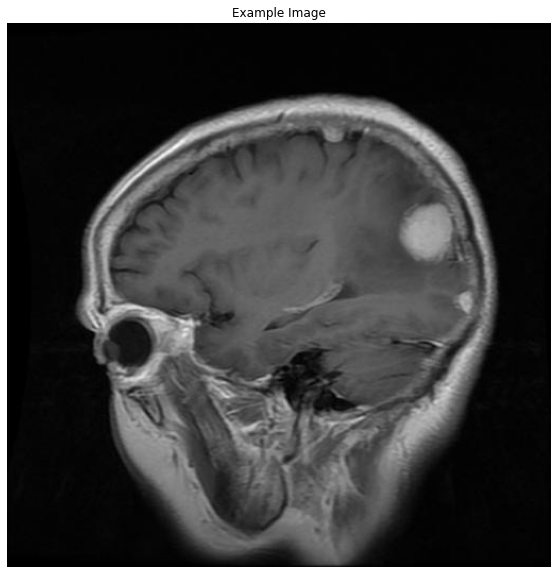

/opt/homebrew/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


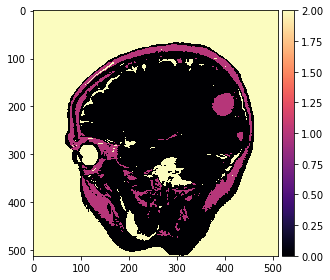

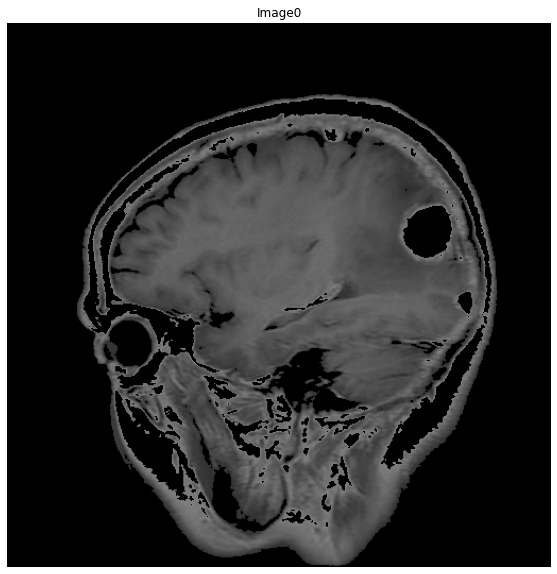

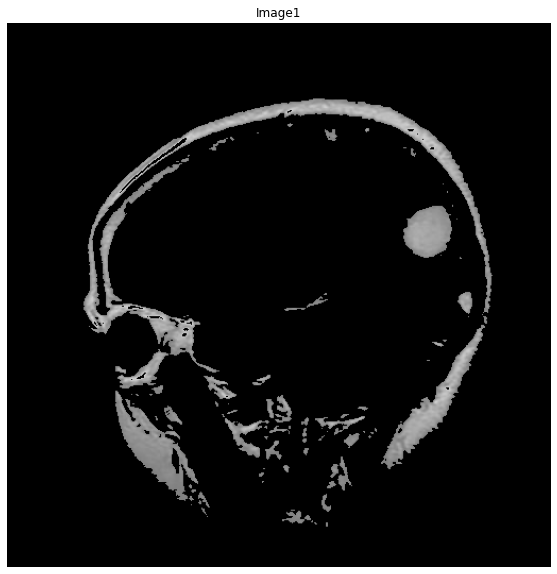

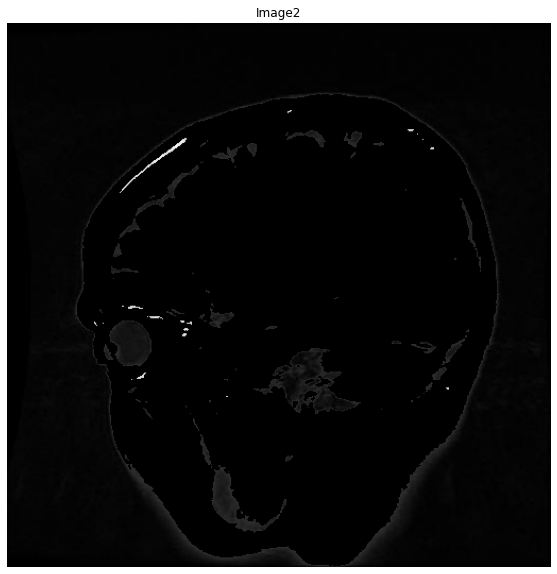

In [228]:
#example output of kmeans clusters to seperate tumor from rest of brain and skull

image = cv2.imread("/Users/akshat/Desktop/ML/archive/Training/meningioma_tumor/m3 (200).jpg", cv2.IMREAD_UNCHANGED)  

ShowImage("Example Image",image, "gray" )
example_frame = image_to_pandas(image)
kmeans = KMeans(n_clusters =  3, random_state = 42).fit(example_frame)
result = kmeans.labels_.reshape(image.shape[0],image.shape[1])

imshow(result, cmap='magma')
masker(image,result,"")
    
    

In [211]:

# This function is used to improve the contrast of given MRI Image
# It uses sigmoid method to enahnce the contrast by given factor
def formula_of_enhancer(C, r, g,b ):
    z1 = 1/(1 + np.exp(-r))
    z2 = 1/(1 + np.exp(-g))
    z3 = 1/(1 + np.exp(-b))
    
    val1 = r + r * C * z1
    val2 = g + g * C * z2
    val3 = b + b * C * z3

    return val1, val2, val3


# This function takes and image and flag for contrast enhancing 
# Depending on the need of contrast enhacing it enhance the contrast of an image
# returns the image
def contrast_enhancing1(im, res):
   
    pixel_map = im.load()
    # Extracting the width and height 
    # of the image:
    width, height = im.size
    
    enhancer = 0
    for i in range(width):
        for j in range(height):
            r,g,b = im.getpixel((i,j))
            if res == True:
                enhancer = 1
            R, G, B = formula_of_enhancer(enhancer, r,g,b)
            pixel_map[i,j] = (int(R), int(G), int(B))                  
                       
    return im

            
# This function does few thingd
# (1) It calls the enhancing function to enhance the contrast if the contrast is low in an image
# (2) Then it converts the image in gray scale
# (3) Then it blurs the image using Gaussian blur to remove noise from image
# (4) Apply Otsu Binary Thresholding to remove the brain tissues and seperate the tumor because in MRI
#        tumor is bright 
# return the final pre-processed img array
def get_thresh_f(img_path):
    
    img_median1 = Image.open(img_path)

    res = is_low_contrast(img_median1, fraction_threshold=0.4)

    enhanced_image = contrast_enhancing1(img_median1, res)


    gray_im =  cv2.cvtColor(np.array(enhanced_image),cv2.COLOR_BGR2GRAY)
    #blur = cv2.GaussianBlur(gray_im, (5,5), 0)
    #T, thresh_f = cv2.threshold(blur, 85, 255, cv2.THRESH_BINARY)
    #ShowImage("img_median_enhanced_thresh", gray_im, "gray")
    return gray_im

    

In [212]:

# This function uses the GLCM to extract the features from the DWT LL, HL, LH, HL 
# It extracts features like contrast, energy, correlation, Homogeneity, ASM, dissimilarity
# Those features will be concatenated for all DWT's
# It will create a feature matrix for the brain tumor image
def get_features_from_GLCM(img):

    img_copy = img
    result = graycomatrix(img_copy, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels = 256)
    contrast = graycoprops(result, 'contrast')

    energy = graycoprops(result, 'energy')

    correlation = graycoprops(result, 'correlation')
  
    Homogeneity = graycoprops(result, 'homogeneity')

    dissimilarity = graycoprops(result, 'dissimilarity')

    ASM = graycoprops(result, 'ASM')
    
    return contrast, energy, correlation, Homogeneity, dissimilarity, ASM



In [213]:

# This function capture all the fetures from DWT images 
# total 11 features for all 4 DWT images have been captured and concatenated to create 
# a feature matrix for the image
# fetures are: Mean, Standard Deviation, Kurtosis, skewness, moment, contrast, energy,
#              correlation, Homogeneity, ASM, dissimilarity
def concat_all_features_to_create_matrix(wav1, wav2, wav3, wav4):
    
    # access all 4 images of DWT
    
    img_ref = {
        "wav1": wav1,
        "wav2": wav2,
        "wav3": wav3,
        "wav4": wav4,
    }
    
    all_features = []
    for i in range(1,5):
        img_name = "wav" + str(i)
        contrast, energy, correlation, Homogeneity, dissimilarity, ASM = get_features_from_GLCM(img_ref[img_name].astype(np.uint8))
        feature_arr = []
        means, dev = cv.meanStdDev(img_ref[img_name])
        
        # find skewness
        inp = img_ref[img_name].ravel()
        skewness_measure = skew(inp)
        kurtosis_measure = kurtosis(inp)
        moment_measure = moment(inp)
        #print("skewness measure and kurtois: ", skewness_measure, kurtosis_measure, moment_measure)
        
        feature_arr.append(means[0][0])
        feature_arr.append(dev[0][0])
        feature_arr.append(skewness_measure)
        feature_arr.append(kurtosis_measure)
        feature_arr.append(moment_measure)
        feature_arr.append(statistics.mean(contrast[0]))
        feature_arr.append(statistics.mean(energy[0]))
        feature_arr.append(statistics.mean(correlation[0]))
        feature_arr.append(statistics.mean(Homogeneity[0]))
        feature_arr.append(statistics.mean(dissimilarity[0]))
        feature_arr.append(statistics.mean(ASM[0]))
        all_features.append(feature_arr)
   
    features = np.array(all_features)
    return features
        
    



In [214]:
# The wavelet was used to analyze different frequencies of an image using different scales.
# Here, we are using discrete wavelet transform (DWT) which is powerful tool for feature extraction
# 2D discrete wavelet transform was applied that resulted in four subbands LL(low–low), 
# HL(high–low),LH(low–high), HH(high–high) with the two-level wavelet decomposition of Region of Interest (ROI).
def apply_DWT(img):
    
    xx = pywt.dwt2(img, 'db1')

    wav1 = np.array(xx[0])
    #print(wav1.shape)

    wav2  = np.array(xx[1][0])

    wav3 = np.array(xx[1][1])

    wav4 = np.array(xx[1][2])
    
    return wav1, wav2, wav3, wav4


In [215]:
# Training class/images feature extraction

path = "/Users/akshat/Desktop/ML/archive/Training_crop/"

tumor_images = os.listdir(path)


Training_features = {}
count_img = 0
for folder in os.listdir(path):
    if folder == ".DS_Store":
        continue
    if folder == "glioma_tumor":
        continue
        
    Training_features[str(folder)] = {} 
    for image in os.listdir(path + folder + "/"):
        if image == ".DS_Store":
            continue
        count_img += 1
        print(image, count_img)
     
        
        contrast_flag = True
        thresh_f = get_thresh_f(path + folder + "/" + image)
        thresh_norm_img = normalize(thresh_f)
        wav1, wav2, wav3, wav4 = apply_DWT(thresh_norm_img)
        feature_for_img = concat_all_features_to_create_matrix(wav1,wav2,wav3,wav4)
        Training_features[str(folder)][image] = feature_for_img


filename = "/Users/akshat/Desktop/ML/archive/features/training_features_kmeans.pickle" 
filehandler = open(filename, 'wb')
pickle.dump(Training_features, filehandler)
    
    

image(213).jpg0.jpg1.jpg2.jpg 1
image (4).jpg0.jpg 2
image(297).jpg0.jpg1.jpg 3
image(128).jpg0.jpg1.jpg2.jpg 4
image(179).jpg0.jpg1.jpg2.jpg 5
image(10).jpg0.jpg1.jpg2.jpg 6
image(193).jpg0.jpg1.jpg2.jpg 7
image(123).jpg0.jpg1.jpg 8
image (5).jpg0.jpg1.jpg 9
image(160).jpg0.jpg1.jpg2.jpg 10
image (20).jpg0.jpg1.jpg2.jpg 11
image(129).jpg0.jpg1.jpg2.jpg 12
image(275).jpg0.jpg1.jpg 13
image(243).jpg0.jpg1.jpg2.jpg 14
image(1).jpg0.jpg1.jpg2.jpg 15
image(17).jpg0.jpg1.jpg 16
image(139).jpg0.jpg 17
image(161).jpg0.jpg1.jpg2.jpg 18
image(192).jpg0.jpg1.jpg2.jpg 19
image(307).jpg0.jpg1.jpg 20
image(312).jpg0.jpg1.jpg 21
image(79).jpg0.jpg 22
image (34).jpg0.jpg1.jpg 23
6.jpg0.jpg1.jpg2.jpg 24
image(18).jpg0.jpg1.jpg 25
image(265).jpg0.jpg 26
image(162).jpg0.jpg1.jpg2.jpg 27
image(308).jpg0.jpg1.jpg 28
image(271).jpg0.jpg 29
image(69).jpg0.jpg1.jpg 30
image(188).jpg0.jpg1.jpg2.jpg 31
image(240).jpg0.jpg1.jpg2.jpg 32
image(131).jpg0.jpg1.jpg 33
image(316).jpg0.jpg 34
image(163).jpg0.jpg1.jpg2

In [216]:

# let's do it for all images in glioma_tumor
path = "/Users/akshat/Desktop/ML/archive/Testing_crop/"

tumor_images = os.listdir(path)

xx = 0
Testing_features = {}
for folder in os.listdir(path):
    if folder == ".DS_Store":
        continue
    if folder == "glioma_tumor":
        continue
    
    Testing_features[str(folder)] = {} 
    for image in os.listdir(path + folder + "/"):
        if image == ".DS_Store":
            continue

        print(image)
        print(xx)
        xx+= 1
        contrast_flag = True
        thresh_f = get_thresh_f(path + folder + "/" + image)
        thresh_norm_img = normalize(thresh_f)
        wav1, wav2, wav3, wav4 = apply_DWT(thresh_norm_img)
        feature_for_img = concat_all_features_to_create_matrix(wav1,wav2,wav3,wav4)
        Testing_features[str(folder)][image] = feature_for_img


filename = "/Users/akshat/Desktop/ML/archive/features/testing_features_kmeans.pickle" 
filehandler = open(filename, 'wb')
pickle.dump(Testing_features, filehandler)
    
    

image(84).jpg0.jpg1.jpg
0
image(41).jpg0.jpg1.jpg2.jpg
1
image(58).jpg0.jpg1.jpg2.jpg
2
image(60).jpg0.jpg
3
image(11).jpg0.jpg1.jpg2.jpg
4
image(66).jpg0.jpg1.jpg
5
image(1).jpg0.jpg1.jpg2.jpg
6
image(55).jpg0.jpg
7
image(99).jpg0.jpg1.jpg
8
image(18).jpg0.jpg1.jpg
9
image(96).jpg0.jpg1.jpg
10
image(101).jpg0.jpg
11
image(17).jpg0.jpg
12
image(36).jpg0.jpg
13
image(3).jpg0.jpg1.jpg2.jpg
14
image(91).jpg0.jpg
15
image(10).jpg0.jpg1.jpg
16
image(42).jpg0.jpg1.jpg2.jpg
17
image(5).jpg0.jpg1.jpg2.jpg
18
image(44).jpg0.jpg1.jpg2.jpg
19
image(82).jpg0.jpg1.jpg
20
image(4).jpg0.jpg1.jpg2.jpg
21
image(68).jpg0.jpg1.jpg
22
image(83).jpg0.jpg
23
image(67).jpg0.jpg1.jpg
24
image(46).jpg0.jpg1.jpg2.jpg
25
image(85).jpg0.jpg1.jpg
26
image(90).jpg0.jpg1.jpg
27
image(6).jpg0.jpg1.jpg2.jpg
28
image(65).jpg0.jpg1.jpg
29
image(52).jpg0.jpg1.jpg2.jpg
30
image(87).jpg0.jpg1.jpg
31
image(89).jpg0.jpg
32
image(40).jpg0.jpg
33
image(16).jpg0.jpg
34
image(13).jpg0.jpg1.jpg
35
image(48).jpg0.jpg1.jpg2.jpg
36


In [1]:
#check and validate features dict
import pickle
train_file = open("/Users/akshat/Desktop/ML/archive/features/training_features_kmeans.pickle",'rb')
training_data = pickle.load(train_file) 

test_file = open("/Users/akshat/Desktop/ML/archive/features/testing_features_kmeans.pickle",'rb')
testing_data = pickle.load(test_file) 

#del training_data["glioma_tumor"]
#del testing_data["glioma_tumor"]
for item in testing_data.items():
    print(item)
    break



('no_tumor', {'image(84).jpg0.jpg1.jpg': array([[ 6.28552661e-02,  1.33403005e-01,  1.94267750e+00,
         2.39038118e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  1.00000000e+00],
       [ 7.73778254e-05,  2.39472298e-02, -2.85752237e-02,
         4.88375370e+01,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  1.00000000e+00],
       [-1.62286191e-04,  2.97828327e-02,  1.20705334e-01,
         4.49619076e+01,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  1.00000000e+00],
       [ 8.78918939e-05,  1.79370718e-02, -1.00367349e+00,
         6.90572624e+01,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  1.00000000e+00]]), 'image(41).jpg0.jpg1.jpg2.jpg': array([[ 4.88317937e-02,  1.38566827e-01,  2.

In [2]:
# prepare Training and Testing dataset for svm classidfier

X_train = []
X_test = []
Y_train = []
Y_test = []


tumor_type_to_number = {
    "no_tumor": 0,
    "meningioma_tumor": 1,
    "pituitary_tumor": 2
  
}

for data in training_data.items():
    tumor_type = data[0]
    print(tumor_type)
    for item in data[1].items():
        image_name = item[0]
        img_arr = item[1]
        #print(img_arr.ravel())
        X_train.append(img_arr.ravel())
        Y_train.append(tumor_type_to_number[tumor_type])
        #print(tumor_type_to_number[tumor_type])

print("\n")
  
for data in testing_data.items():
    tumor_type = data[0]
    print(tumor_type)
    for item in data[1].items():
        image_name = item[0]
        img_arr = item[1]
        #print(img_arr.ravel())
        X_test.append(img_arr.ravel())
        Y_test.append(tumor_type_to_number[tumor_type])
        #print(tumor_type_to_number[tumor_type])

    
    

no_tumor
meningioma_tumor
pituitary_tumor


no_tumor
meningioma_tumor
pituitary_tumor


Ideal: 0.705
> folds=2, accuracy=0.688 (0.681,0.694)
> folds=3, accuracy=0.690 (0.678,0.702)
> folds=4, accuracy=0.691 (0.650,0.729)
> folds=5, accuracy=0.692 (0.680,0.715)
> folds=6, accuracy=0.696 (0.670,0.740)
> folds=7, accuracy=0.700 (0.655,0.757)
> folds=8, accuracy=0.696 (0.656,0.750)
> folds=9, accuracy=0.700 (0.652,0.762)
> folds=10, accuracy=0.702 (0.654,0.751)
> folds=11, accuracy=0.702 (0.629,0.758)
> folds=12, accuracy=0.702 (0.632,0.753)
> folds=13, accuracy=0.703 (0.620,0.758)
> folds=14, accuracy=0.702 (0.623,0.753)
> folds=15, accuracy=0.702 (0.610,0.779)
> folds=16, accuracy=0.702 (0.648,0.781)
> folds=17, accuracy=0.701 (0.608,0.777)
> folds=18, accuracy=0.703 (0.614,0.779)
> folds=19, accuracy=0.703 (0.620,0.787)
> folds=20, accuracy=0.701 (0.559,0.786)
> folds=21, accuracy=0.703 (0.612,0.786)
> folds=22, accuracy=0.705 (0.613,0.777)
> folds=23, accuracy=0.704 (0.562,0.787)
> folds=24, accuracy=0.704 (0.600,0.800)
> folds=25, accuracy=0.704 (0.537,0.780)
> folds=26,

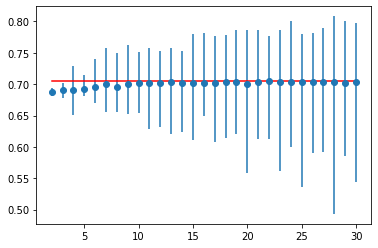

In [34]:
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.model_selection import cross_val_predict


# create the dataset
def get_dataset():
    X, y = X_train, Y_train
    return X, y
 
# retrieve the model to be evaluate
def get_model_SVM(kernel_type):
    model = make_pipeline(StandardScaler(), SVC(kernel=kernel_type, gamma='auto'))
    return model
 
# evaluate the model using a given test condition
def evaluate_model(cv, X, y, kernel_type):
    # get the model
    model = get_model_SVM(kernel_type)
    # evaluate the model
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    # return scores
    return mean(scores), scores.min(), scores.max(), model
 
# calculate the ideal test condition
ideal, _, _, _ = evaluate_model(LeaveOneOut(), X_train, Y_train, "rbf")
print('Ideal: %.3f' % ideal)
# define folds to test
folds = range(2,31)
# record mean and min/max of each set of results
means, mins, maxs = list(),list(),list()

final_cv = 0
max_accuracy = 0

# evaluate each k value
for k in folds:
    # define the test condition
    cv = KFold(n_splits=k, shuffle=True, random_state=1)
    # evaluate k value
    k_mean, k_min, k_max, model = evaluate_model(cv, X_train, Y_train, "rbf")
    y_pred = cross_val_predict(model, np.array(X_test), Y_test, cv=cv)
    
    accuracy = k_mean
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        final_cv = cv
    
    # report performance
    print('> folds=%d, accuracy=%.3f (%.3f,%.3f)' % (k, k_mean, k_min, k_max))
    # store mean accuracy
    means.append(k_mean)
    # store min and max relative to the mean
    mins.append(k_mean - k_min)
    maxs.append(k_max - k_mean)
# line plot of k mean values with min/max error bars
pyplot.errorbar(folds, means, yerr=[mins, maxs], fmt='o')
# plot the ideal case in a separate color
pyplot.plot(folds, [ideal for _ in range(len(folds))], color='r')
# show the plot
pyplot.show()



In [35]:
tumor_number_to_type = {
    0: "no_tumor",
    1: "meningioma_tumor",
    2: "pituitary_tumor"
}

# per class accuracy funtion
def class_accuracy_function(X, Y):
    
    per_class_test_acc = {}
    class_wise_count_test = {}
    for val in Y:
        if tumor_number_to_type[val] not in class_wise_count_test:
            class_wise_count_test[tumor_number_to_type[val]] = 0
        else:
            class_wise_count_test[tumor_number_to_type[val]] += 1
    
    for i, item in enumerate(Y):
        if item == X[i]:
            if tumor_number_to_type[item] not in per_class_test_acc:
                per_class_test_acc[tumor_number_to_type[item]] = 0
            else:
                per_class_test_acc[tumor_number_to_type[item]] += 1
                
    for item in per_class_test_acc.items():
        per_class_test_acc[item[0]] = per_class_test_acc[item[0]] / class_wise_count_test[item[0]]
    
                
    return per_class_test_acc
    



In [36]:
# ROC curves typically feature true positive rate on the Y axis, and false positive rate on the X axis. 
# This means that the top left corner of the plot is the “ideal” point - a false positive rate of zero,
# and a true positive rate of one. This is not very realistic, but it does mean that a larger area under 
#the curve (AUC) is usually better.
#The “steepness” of ROC curves is also important, since it is ideal to maximize the true positive rate 
# while minimizing the false positive rate.

def ROC(y_test_old, y_score):
    n_classes = 3
    lw = 2
    y_test = []
    for val in y_test_old:
        if val == 0:
            arr = [1,0,0]
        elif val == 1:
            arr = [0,1,0]
        else:
            arr = [0,0,1]
        y_test.append(arr)
    y_test = np.array(y_test)    
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(3):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= 3

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(tumor_number_to_type[i], roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("-- ROC --")
    plt.legend(loc="lower right")
    plt.show()

In [74]:
# function to create confusion matrix
def plot_confusion_matrix(classifier, X_test, y_test, title):
    class_names = ["no_tumor","meningioma", "Pituitary"]
    # Plot non-normalized confusion matrix
    titles_options = [
        (title, "true")
    ]
    for title, normalize in titles_options:
        disp = ConfusionMatrixDisplay.from_estimator(
            classifier,
            X_test,
            y_test,
            display_labels=class_names,
            cmap=plt.cm.Blues,
            normalize=normalize,
        )
        disp.ax_.set_title(title)
        
        print("\n")
        print("Confusion Matrix")
        print(disp.confusion_matrix)
        time.sleep(2)
    plt.title(title, color="red")
    plt.show()


Linear kernel


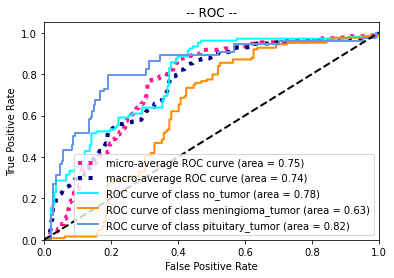

Accuracy Testing in percentage:  67.98679867986799
('no_tumor', 0.7788461538461539)
('meningioma_tumor', 0.6178861788617886)
('pituitary_tumor', 0.6301369863013698)


Acccuracy Training in percentage:  68.1640625
('no_tumor', 0.5714285714285714)
('meningioma_tumor', 0.610909090909091)
('pituitary_tumor', 0.805115712545676)


Confusion Matrix
[[0.00952381 0.52380952 0.46666667]
 [0.         0.85483871 0.14516129]
 [0.         0.56756757 0.43243243]]


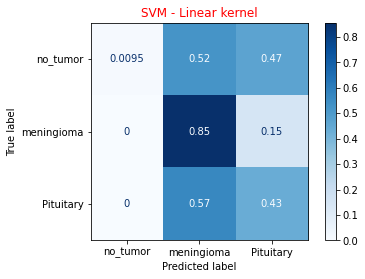

Classification Reoprt
              precision    recall  f1-score   support

    no_tumor       0.71      0.78      0.74       105
  meningioma       0.68      0.62      0.65       124
   pituitary       0.64      0.64      0.64        74

    accuracy                           0.68       303
   macro avg       0.67      0.68      0.68       303
weighted avg       0.68      0.68      0.68       303





Poynomial kernel


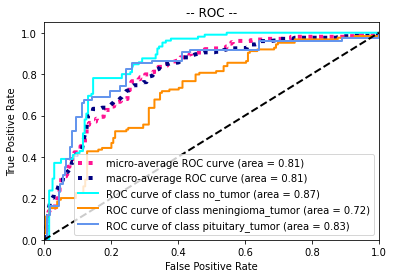

Accuracy Testing in percentage:  49.504950495049506
('no_tumor', 0.22115384615384615)
('meningioma_tumor', 0.9349593495934959)
('pituitary_tumor', 0.1232876712328767)


Acccuracy Training in percentage:  53.857421875
('no_tumor', 0.46616541353383456)
('meningioma_tumor', 0.12606060606060607)
('pituitary_tumor', 0.9866017052375152)


Confusion Matrix
[[0.         1.         0.        ]
 [0.         0.92741935 0.07258065]
 [0.         0.81081081 0.18918919]]


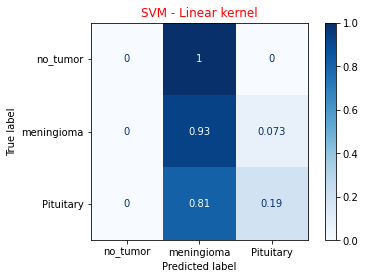

Classification Reoprt
              precision    recall  f1-score   support

    no_tumor       0.86      0.23      0.36       105
  meningioma       0.45      0.94      0.60       124
   pituitary       0.67      0.14      0.22        74

    accuracy                           0.50       303
   macro avg       0.66      0.43      0.40       303
weighted avg       0.64      0.50      0.43       303





RBF kernel


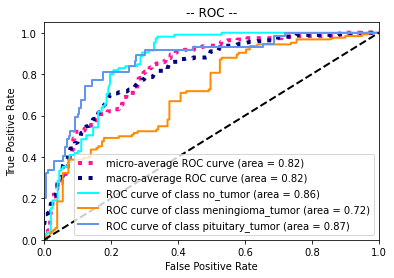

Accuracy Testing in percentage:  66.66666666666666
('no_tumor', 0.7019230769230769)
('meningioma_tumor', 0.6910569105691057)
('pituitary_tumor', 0.5616438356164384)


Acccuracy Training in percentage:  70.458984375
('no_tumor', 0.6867167919799498)
('meningioma_tumor', 0.5854545454545454)
('pituitary_tumor', 0.8319123020706456)


Confusion Matrix
[[0.         0.99047619 0.00952381]
 [0.         0.92741935 0.07258065]
 [0.         0.85135135 0.14864865]]


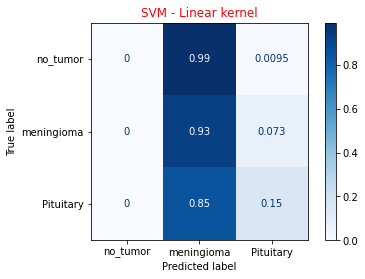

Classification Reoprt
              precision    recall  f1-score   support

    no_tumor       0.79      0.70      0.74       105
  meningioma       0.61      0.69      0.65       124
   pituitary       0.63      0.57      0.60        74

    accuracy                           0.67       303
   macro avg       0.67      0.66      0.66       303
weighted avg       0.67      0.67      0.67       303



In [77]:
# svm classifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import svm, datasets
import time
from sklearn.metrics import classification_report

# svm classification function takes kernel type and dataset
def SVM_classfication(kernel_type, X_train, X_test, Y_train, Y_test):
    X_train, Y_train = get_dataset()

    model = get_model_SVM(kernel_type)
    score_test = model.fit(X_train, Y_train).decision_function(X_test)
    #ROC
    ROC(Y_test, score_test)

    
    k_mean, k_min, k_max, model = evaluate_model(final_cv, np.array(X_test), Y_test, kernel_type)
    y_pred_test = cross_val_predict(model, np.array(X_test), Y_test, cv=final_cv)

 
    per_class_test_acc = class_accuracy_function(y_pred_test, Y_test)
    
    xx = 0
    for i, item in enumerate(Y_test):
        if item == y_pred_test[i]:
            xx += 1
    
    print("Accuracy Testing in percentage: ", xx/len(Y_test) * 100)
    for item in per_class_test_acc.items():
        print(item)


    
    
    ####################################################################################
    
    model = get_model_SVM(kernel_type)
    k_mean, k_min, k_max, model = evaluate_model(final_cv, np.array(X_test), Y_test, kernel_type)
    y_pred_train = cross_val_predict(model, np.array(X_train), Y_train, cv=final_cv)
    
    per_class_train_acc = class_accuracy_function(y_pred_train, Y_train)


    yy = 0
    for i, item in enumerate(Y_train):
        if item == y_pred_train[i]:
            yy += 1
    
    print("\n")
    print("Acccuracy Training in percentage: ", yy / len(Y_train) * 100)
    for item in per_class_train_acc.items():
        print(item)
    
    # Confusion Matrix
    classifier = svm.SVC(kernel=kernel_type, C=0.01).fit(X_train, Y_train)
    title = "SVM - Linear kernel"
    plot_confusion_matrix(classifier, X_test, Y_test, title)
    
    #classification report 
    target_names = ["no_tumor", "meningioma", "pituitary"]
    print("Classification Reoprt")
    print(classification_report(Y_test, y_pred_test, target_names=target_names))


print("Linear kernel")
SVM_classfication("linear", X_train, X_test, Y_train, Y_test)



print("\n")
print("\n")
print("Poynomial kernel")
SVM_classfication("poly", X_train, X_test, Y_train, Y_test)

print("\n")
print("\n")

print("RBF kernel")
SVM_classfication("rbf", X_train, X_test, Y_train, Y_test)




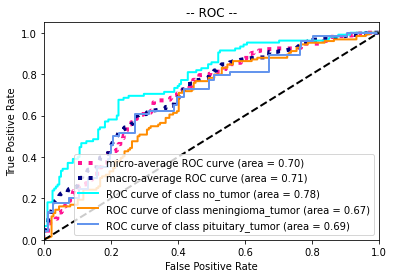

Accuracy Testing in percentage:  51.15511551155115
('no_tumor', 0.1346153846153846)
('meningioma_tumor', 0.8617886178861789)
('pituitary_tumor', 0.4383561643835616)


Accuracy Training in percentage:  0.5410353897656623
('no_tumor', 0.10776942355889724)
('meningioma_tumor', 0.64)
('pituitary_tumor', 0.6650426309378806)


Confusion Matrix
[[0.14285714 0.5047619  0.35238095]
 [0.02419355 0.86290323 0.11290323]
 [0.         0.55405405 0.44594595]]


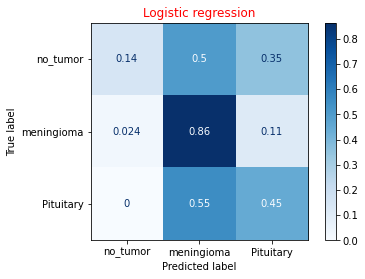

Classification Reoprt
              precision    recall  f1-score   support

    no_tumor       0.83      0.14      0.24       105
  meningioma       0.53      0.86      0.66       124
   pituitary       0.39      0.45      0.42        74

    accuracy                           0.51       303
   macro avg       0.59      0.48      0.44       303
weighted avg       0.60      0.51      0.46       303



In [79]:
# multiclass logistic regression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import model_selection
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

def MultiCalssLogisticRegression(X_train, X_test, Y_train, Y_test):
    
    lm = linear_model.LogisticRegression(multi_class='ovr', solver='liblinear')
    score_test = lm.fit(X_train, Y_train).decision_function(X_test)
    #ROC
    ROC(Y_test, score_test)
    
    cv = KFold(n_splits=10, random_state=1, shuffle=True)
    
    scores = cross_val_score(lm, X_train, Y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    
    lm.fit(np.array(X_train), np.array(Y_train))
    
    Y_pred_test = lm.predict(np.array(X_test))
    
    train_acc = 0
    test_acc = 0

    xx = 0
    for i, item in enumerate(Y_test):
        #print(item)
        if item == Y_pred_test[i]:
            xx += 1

    print("Accuracy Testing in percentage: ", xx/len(Y_test) * 100)
    per_class_test_acc = class_accuracy_function(Y_pred_test, Y_test)
    for item in per_class_test_acc.items():
        print(item)

    #train accuracy
    Y_pred_train = lm.predict(np.array(X_train))
    yy = 0
    for i, item in enumerate(Y_train):
        if item == Y_pred_train[i]:
            yy += 1
            
    print("\n")
    print("Accuracy Training in percentage: ", np.mean(scores))
    per_class_train_acc = class_accuracy_function(Y_pred_train, Y_train)
    for item in per_class_train_acc.items():
        print(item)

    # Confusion Matrix
    classifier = lm.fit(X_train, Y_train)
    title = "Logistic regression"
    plot_confusion_matrix(classifier, X_test, Y_test, title)
    
    #classification report 
    target_names = ["no_tumor", "meningioma", "pituitary"]
    print("Classification Reoprt")
    print(classification_report(Y_test, Y_pred_test, target_names=target_names))


    
MultiCalssLogisticRegression(X_train, X_test, Y_train, Y_test)  
    